In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from skimage import io
import Image

In [2]:
EPOCH = 20                # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 12
INPUT_SIZE = 227         # img input size
LR = 0.001               # learning rate
DOWNLOAD_MNIST = False   # set to True if haven't download the data
TEST = False

In [3]:
class GroceryDataset(Dataset):
    data_transform = transforms.Compose([
        transforms.Resize(227),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    """Frocery dataset."""    
    def __init__(self, fpath = '/home/arg_ws3/freiburg_groceries_dataset/images/',\
                 transform = data_transform):
        self.fpath = fpath
        self.filepath = os.path.join(self.fpath + 'path.txt')
        self.cls = []
        with open(self.filepath) as f:
            self.flines = f.readlines()
        for i in self.flines:
            cls = i.split('/')[1]
            if cls not in self.cls:
                self.cls.append(cls)
        self.length = len(self.flines)
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        fsplit = self.flines[idx].split('/')
        #print fsplit[1], fsplit[2]
        label = torch.tensor(self.cls.index(fsplit[1]))
        #label = fsplit[1]
        image_path = self.fpath + fsplit[1] + '/' + fsplit[2].strip()
        img = self.transform(Image.open(image_path))
        #item = {'image': img, 'landmarks': label}
        return img, label

In [4]:
class CaffeNet(nn.Module):
    def __init__(self):
        super(CaffeNet, self).__init__()
        '''self.pool2x2 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(1, 16, 5, 1, 2)
        self.fc1 = nn.Linear(16*5*5, 120)'''
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 96, 11, 4, 0), #in, out, kernel, stride, padding
            nn.ReLU(),
            nn.MaxPool2d((3, 3), 2), #kernel size, stride
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2), #in, out, kernel, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), #kernel size, stride
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1), #in, out, kernel, stride, padding
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1), #in, out, kernel, stride, padding
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1), #in, out, kernel, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), #kernel size, stride
        )
        self.fc6 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout2d(0.5)
        )
        self.fc7 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout2d(0.5)
        )
        self.out = nn.Linear(4096, 25)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 256*6*6) #flatten data
        x = self.fc6(x)
        x = self.fc7(x)
        output = self.out(x)
        return output

In [5]:
def load_mnist_data(bt = BATCH_SIZE, fpath = './mnist'):
    data_transform = transforms.Compose([
            transforms.Resize(227),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    train_data = torchvision.datasets.MNIST(
        root = fpath,
        train = True, # this is training data
        transform = data_transform
    )
    train_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                               batch_size = bt, \
                                               shuffle = True)
    return train_loader

In [6]:
def load_grocery_data(bt = BATCH_SIZE, fpath = './freiburg_groceries_dataset/images'):
    data_transform = transforms.Compose([
            transforms.Resize(227),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    train_data = datasets.ImageFolder(root = fpath, \
                                           transform = data_transform)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                                 batch_size = bt, \
                                                 shuffle = True)
    return train_loader

In [7]:
def load_test_data(bt = 1, dataset = 'grocery'):
    if dataset == 'grocery':
        test_loader = load_grocery_data(bt = bt)
    elif dataset == 'mnist':
        test_loader = load_mnist_data(bt = bt)
    data_iter = iter(test_loader)
    return data_iter

In [8]:
def pretrained():
    #caffenet = CaffeNet()
    pretrain_model = './py_model/bvlc_reference_caffenet.caffemodel.pth'
    pre_trained = torch.load(pretrain_model)
    #pre_param = pre_trained.items()
    #cf = caffenet.state_dict().items()
    #for k, v in cf:
    #    print k
    #print '========='
    #for k, v in pre_param:
    #    print kdd
    #print pre_trained['conv5.bias'].size()
    #print caffenet.state_dict()['conv5.0.bias'].size()
    #print cf['conv1.0.bias']
    #print new
    #model_state = caffenet.state_dict()
    #pre_param = state_dict['model'].items()
    #pretrained_state = ({k:v for k,v in pre_param if k in fasterRCNN.state_dict() \
    #                  and v.size() == caffenet.state_dict()[k].size()})
    #model_state.update(pretrained_state)
    #caffenet.load_state_dict(model_state)

In [9]:
def vis_img(data):
    img = data[0][0].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    print img.shape
    img = cv2.resize(img, (227, 227)) 
    print img.shape
    plt.imshow(img, cmap='gray')
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=0)
    img = torch.from_numpy(img).cuda()

In [14]:
def test_caffenet(weight_path = './py_model/net_19.pth'):
    data_iter = load_test_data(dataset = 'grocery')
    #Define model
    print('Load training model')
    caffenet = torch.load(weight_path).cuda()
    data = next(data_iter)
    outputs = caffenet(data[0].cuda())
    pred_y = torch.max(outputs, 1)[1].cpu().numpy()
    print 'Prediction: ', pred_y
    print 'Ground truth: ', data[1].cpu().numpy()
    vis_img(data)

Load training model
Prediction:  [5]
Ground truth:  [5]
(227, 227, 3)
(227, 227, 3)


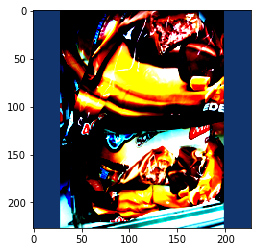

In [27]:
test_caffenet()

In [12]:
def train_caffenet():
    #Define training data
    train_loader = load_grocery_data()
    #Define model, optimizer and loss function
    print('Load training model')
    caffenet = CaffeNet().cuda()
    print caffenet
    #optimizer = torch.optim.Adam(caffenet.parameters(), lr = LR)   # optimize all cnn parameters
    optimizer = torch.optim.SGD(caffenet.parameters(), lr = LR, momentum=0.9, weight_decay=0.0005)
    loss_func = nn.CrossEntropyLoss().cuda()
    
    running_loss = 0.
    cnt = 0
    for epoch in range(EPOCH):
        print('========== Epoch: ', epoch, ' ==========')
        for step, data in enumerate(train_loader):
            cnt = cnt + 1
            imgs = data[0].cuda()
            labels = data[1].cuda()
            optimizer.zero_grad()
            outputs = caffenet(imgs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            if cnt % 50 == 0:
                print 'loss: ', loss.item()
        model_name = './py_model/net_{}.pth'.format(epoch)
        torch.save(caffenet, model_name)
        print('----- Save model: {} -----'.format(model_name))
    print('Finish Training')

In [13]:
train_caffenet()

Load training model
CaffeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc6): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout2d(p=0.5)
  )


/usr/local/lib/python2.7/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CaffeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


----- Save model: ./py_model/net_0.pth -----
('========== Epoch: ', 1, ' ==========')
loss:  3.25415539742
loss:  3.00484967232
loss:  3.09596538544
loss:  3.08698964119
loss:  3.01183128357
loss:  3.18264698982
loss:  3.18581366539
loss:  3.04953861237
----- Save model: ./py_model/net_1.pth -----
('========== Epoch: ', 2, ' ==========')
loss:  3.22390151024
loss:  2.92145657539
loss:  3.04437541962
loss:  3.07030463219
loss:  2.92821907997
loss:  3.27428412437
loss:  3.33941173553
loss:  3.15236759186
----- Save model: ./py_model/net_2.pth -----
('========== Epoch: ', 3, ' ==========')
loss:  3.15156555176
loss:  2.90105175972
loss:  2.82602763176
loss:  3.19890141487
loss:  3.22904229164
loss:  3.02810025215
loss:  3.13735556602
loss:  3.24197697639
loss:  3.06538105011
----- Save model: ./py_model/net_3.pth -----
('========== Epoch: ', 4, ' ==========')
loss:  3.1712706089
loss:  2.78643012047
loss:  3.09583282471
loss:  3.04928517342
loss:  2.86074948311
loss:  2.91160607338
loss: 